In [1]:
!git clone https://github.com/fja05680/sp500

fatal: destination path 'sp500' already exists and is not an empty directory.


# LIBRARIES

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pickle

from collections import OrderedDict

from sklearn.covariance import LedoitWolf

from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt import base_optimizer

from gurobipy import Model, GRB, quicksum, QuadExpr

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch

# DOWNLOADING DATA

In [3]:
# df = pd.read_csv('sp500/S&P 500 Historical Components & Changes(03-10-2025).csv', parse_dates=['date'])
# df

In [4]:
# tickers = df.iloc[-1]['tickers'].split(',')
# tickers = set(map(str.strip, tickers))
# tickers.add('^GSPC')

In [5]:
# today = pd.to_datetime('today')
# start = today - pd.DateOffset(years = 10)

In [6]:
# data = yf.download(
#     tickers=list(tickers), 
#     start=start, 
#     end=today,
#     auto_adjust=False, 
#     progress=True, 
#     group_by='ticker'
# )

In [7]:
# data

In [8]:
# prices = data.xs('Adj Close', level=1, axis=1)
# prices

In [9]:
# prices = prices.ffill().bfill()
# prices = prices.dropna(axis=1, how='all')
# prices = prices[sorted(prices.columns)]
# prices

In [10]:
# prices.columns

In [11]:
# prices.to_csv('./prices.csv', index_label='Date')

# READING DATA

In [12]:
prices = pd.read_csv('./data/prices.csv', index_col='Date', parse_dates=True)
prices

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-06,36.274502,28.219820,44.975479,144.710007,41.130566,21.965755,82.638290,80.500000,51.819889,35.814003,...,21.559919,90.775871,24.113523,53.255875,31.981432,54.003380,97.434189,111.839996,44.890648,2068.760010
2015-07-07,36.670807,28.150394,45.199627,144.710007,41.519203,22.032318,83.775925,80.589996,51.648766,35.851231,...,21.784145,97.303535,24.808968,53.475277,32.096119,53.538803,98.311852,112.320000,44.408337,2081.340088
2015-07-08,35.712341,27.451612,44.606300,144.710007,40.725368,21.870667,82.876022,79.989998,50.475296,35.382034,...,21.444403,91.003075,24.677202,52.894501,31.381489,51.889015,96.672890,108.470001,43.109844,2046.680054
2015-07-09,35.869007,26.891697,44.810665,144.710007,40.675755,21.750219,82.986389,80.470001,49.619640,35.069263,...,21.240557,91.929359,24.399027,52.655746,31.355017,52.407177,95.687759,108.440002,43.193321,2051.310059
2015-07-10,36.311371,27.610632,45.641342,144.710007,41.287674,21.997452,83.860832,80.589996,50.124878,35.158630,...,21.260944,90.793335,24.560064,53.055847,31.222681,54.116547,95.660866,109.750000,43.555046,2076.620117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,118.919556,201.080002,182.309998,134.520004,134.380005,90.320000,295.459991,385.829987,236.960007,51.980000,...,25.850000,94.680000,67.779999,109.379997,128.229996,148.410004,91.459999,309.260010,156.169998,6173.069824
2025-06-30,117.762001,205.169998,185.619995,132.339996,136.009995,91.050003,298.890015,386.880005,238.020004,52.779999,...,25.690001,93.669998,68.099998,107.800003,129.360001,148.179993,91.209999,308.359985,155.949997,6204.950195
2025-07-01,120.449997,207.820007,189.990005,135.410004,136.259995,91.500000,302.619995,392.100006,240.639999,54.450001,...,26.240000,101.959999,68.709999,109.239998,131.000000,150.369995,94.059998,315.480011,159.190002,6198.009766


In [13]:
benchmark = prices.pop('^GSPC')

# USING NORMAL CORR MATRIX

In [14]:
pct_returns = prices.pct_change().dropna()

In [15]:
corr = pct_returns.corr()

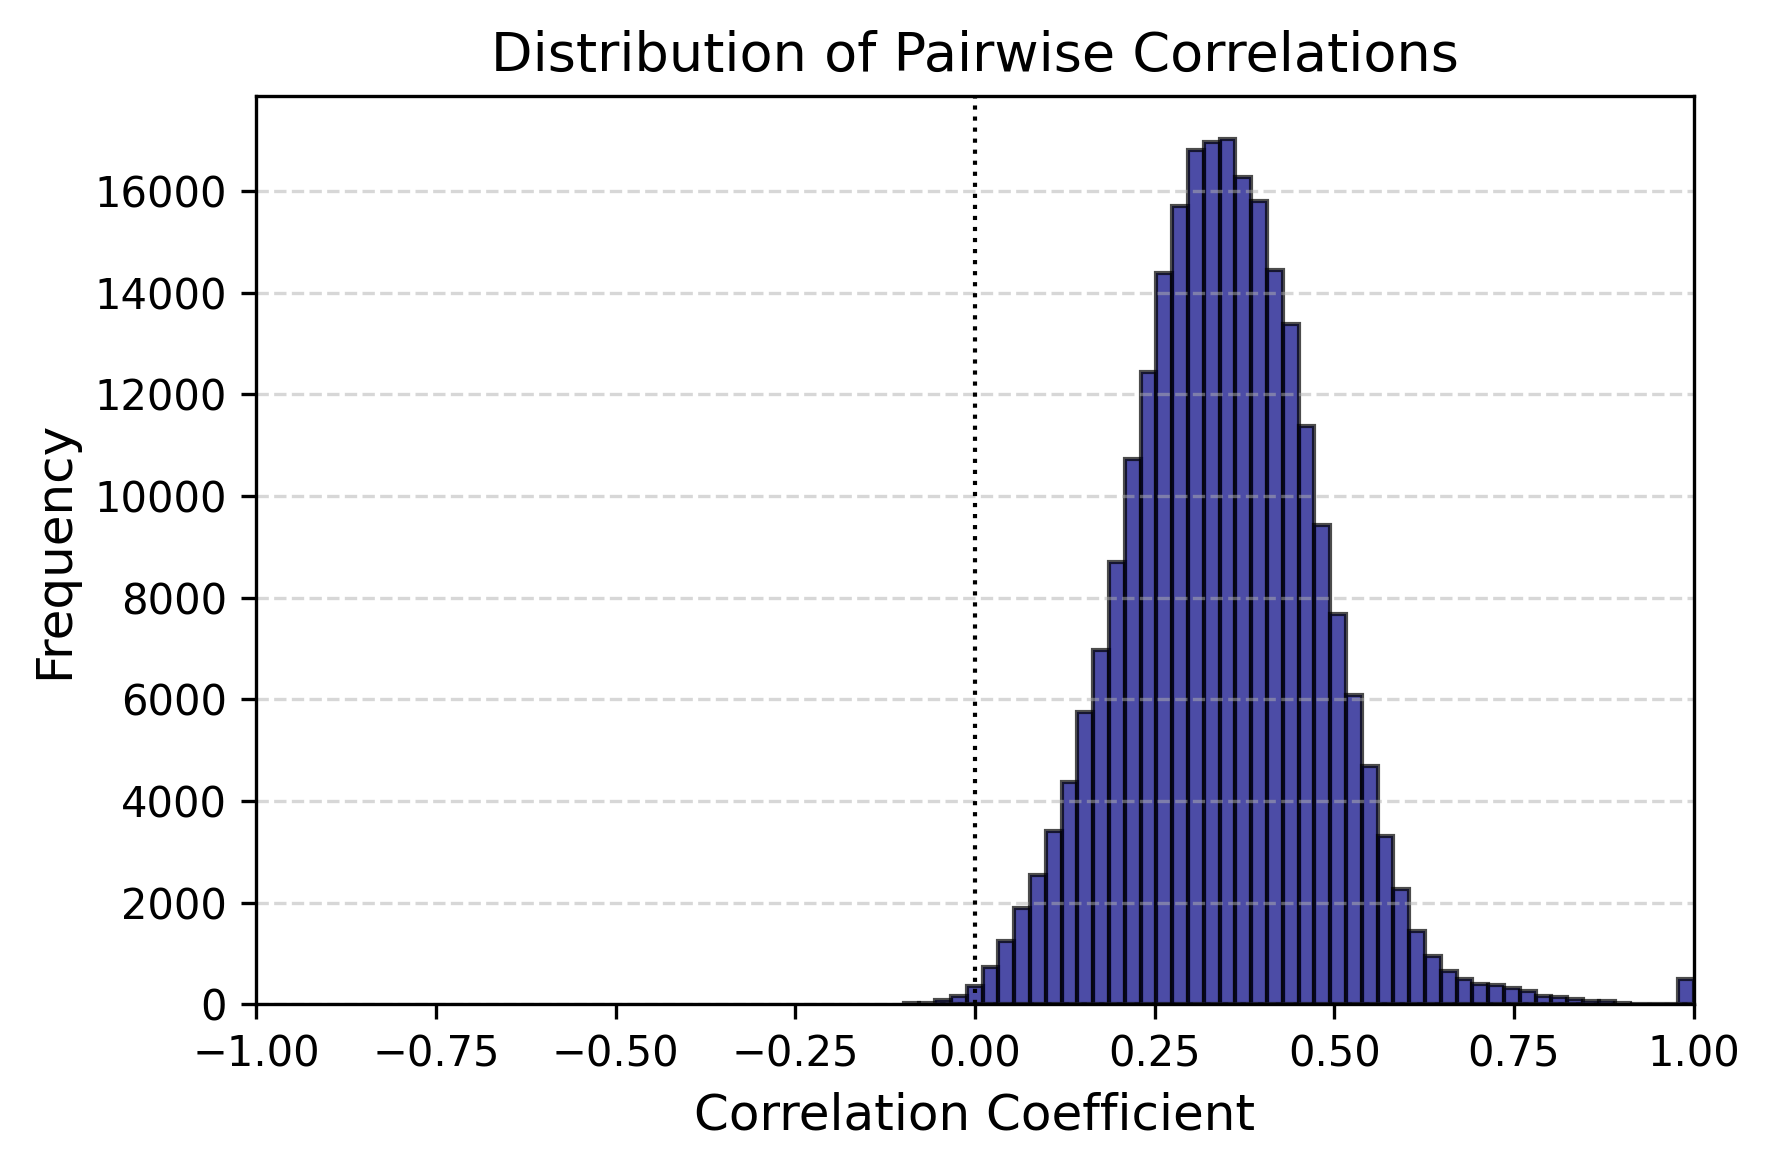

In [16]:
plt.figure(figsize=(6, 4), dpi=300)
plt.hist(corr.values.flatten(), bins=50, color='navy', edgecolor='black', alpha=0.7)

plt.axvline(x=0, color='black', linestyle='dotted', linewidth=1)
plt.xlim(-1, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Pairwise Correlations", fontsize=13)
plt.tight_layout()

plt.show()


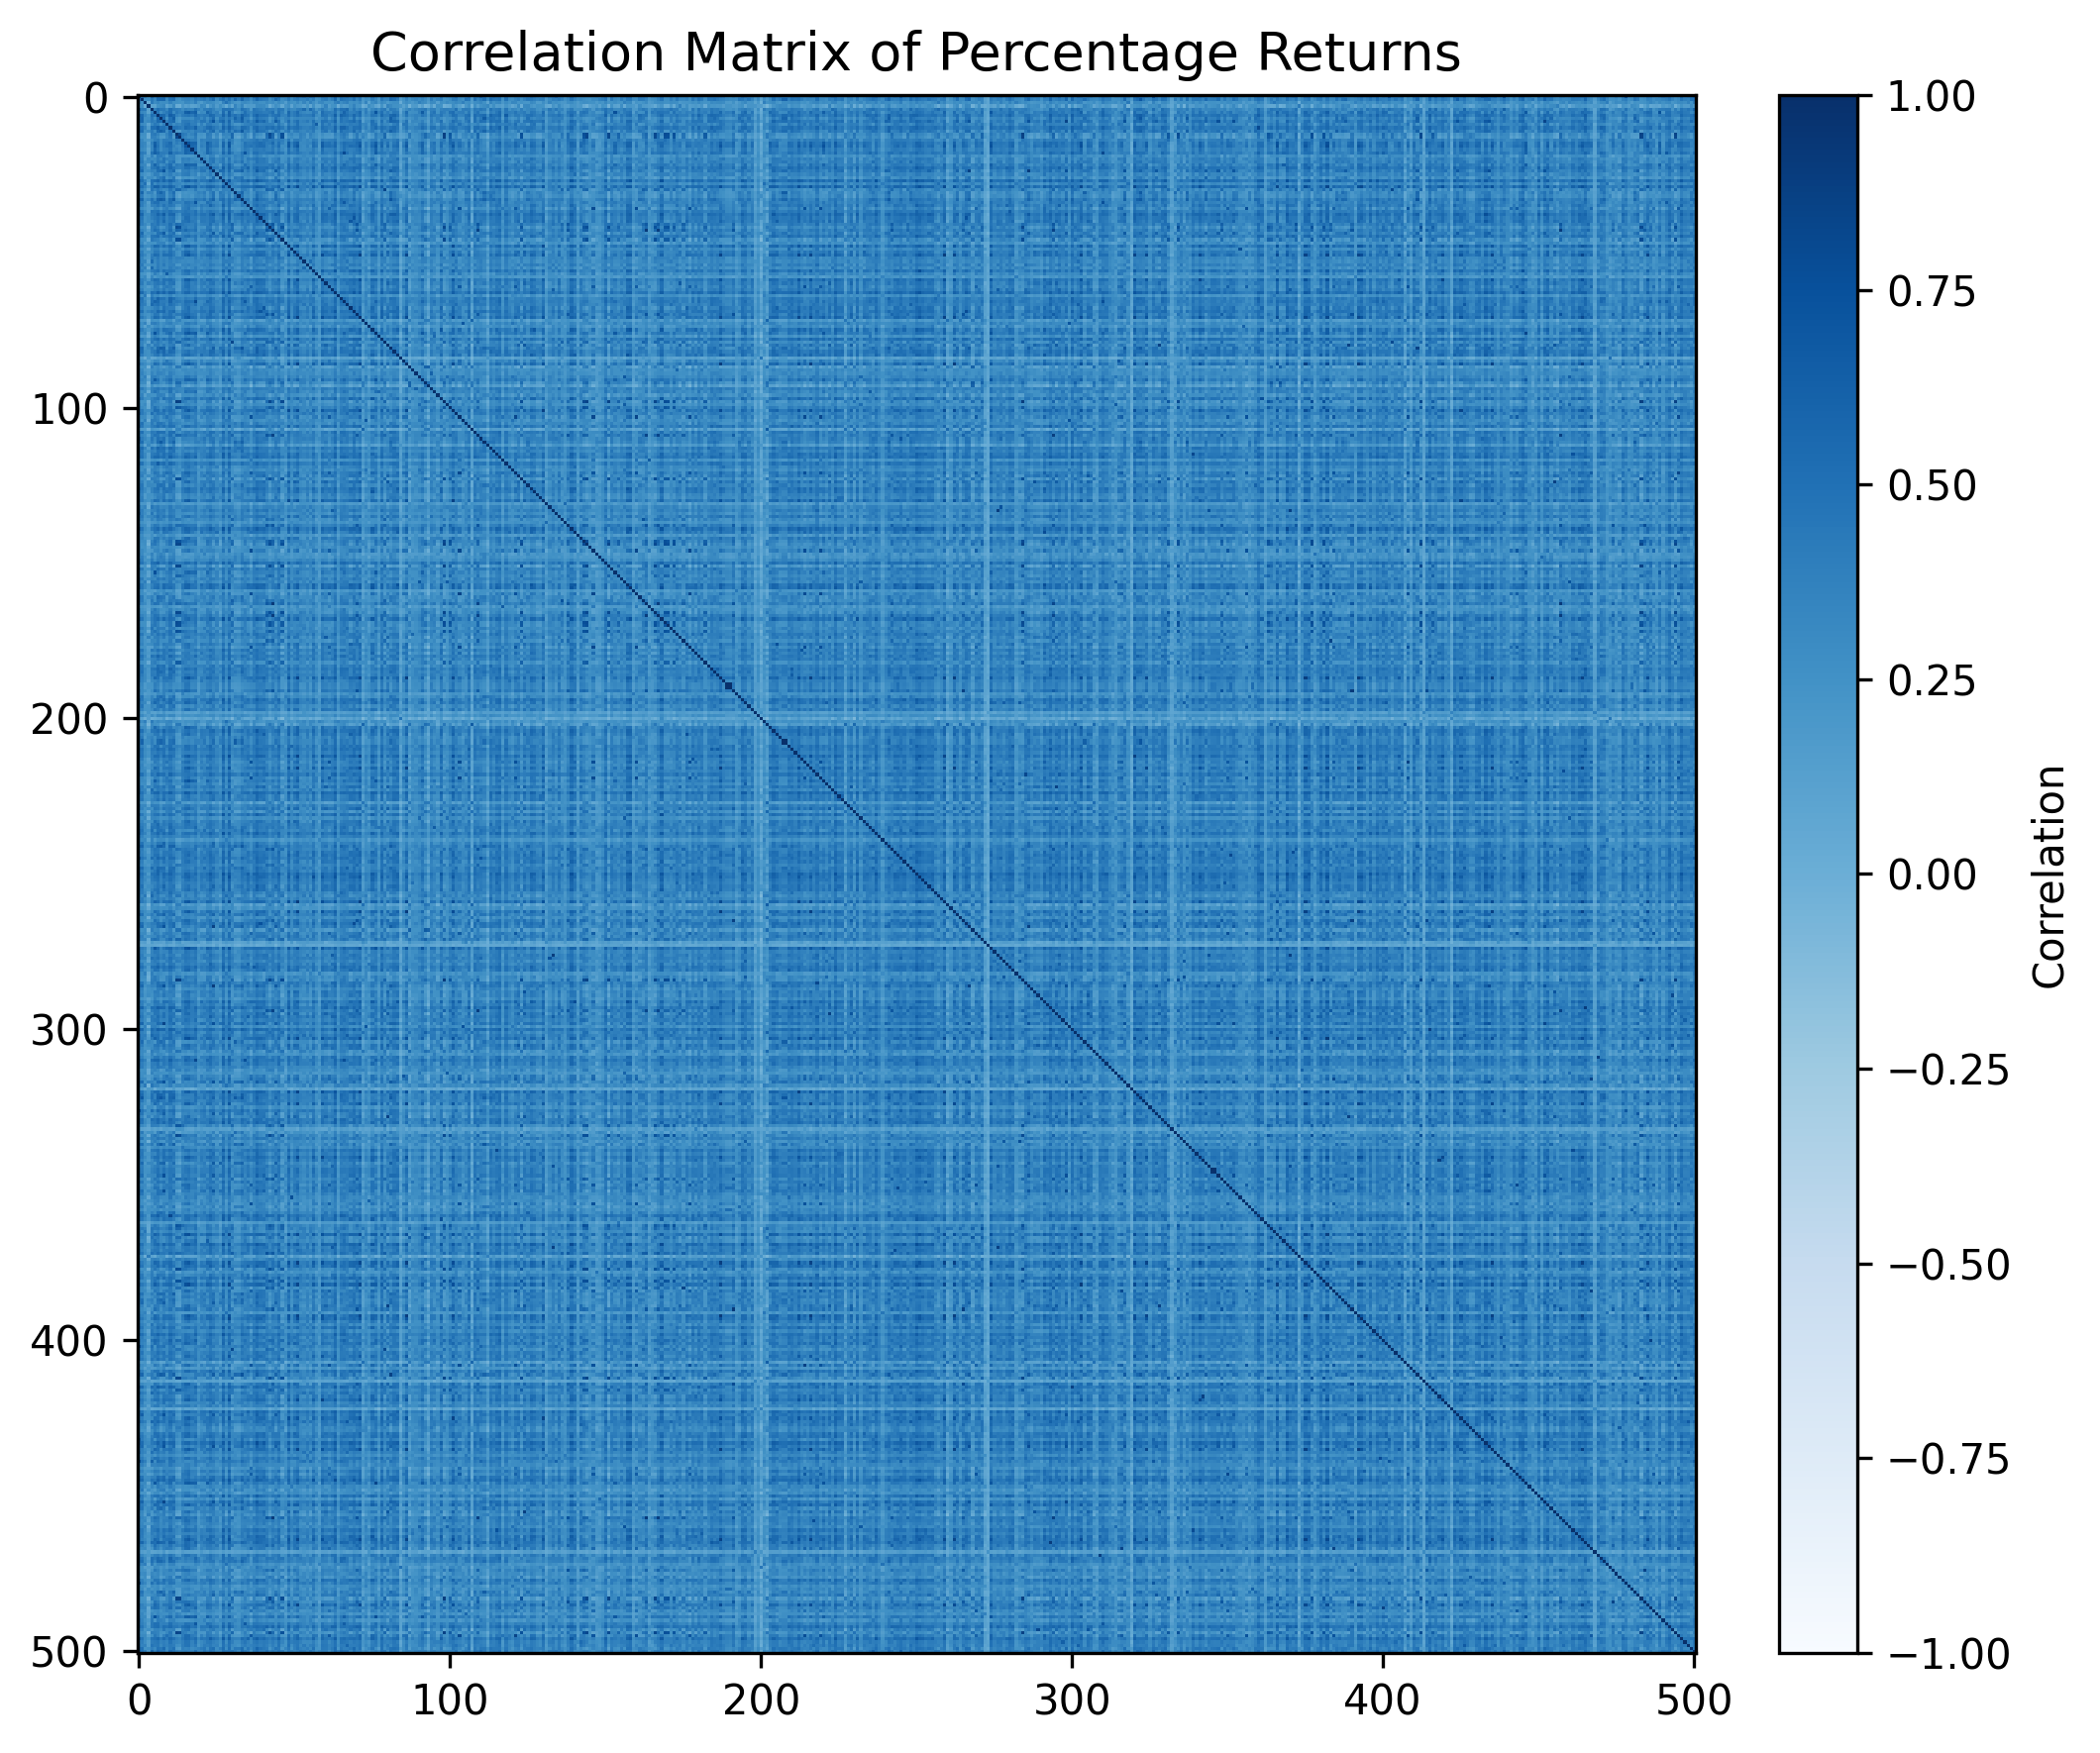

In [17]:
plt.figure(figsize=(8, 6), dpi=300)
im = plt.imshow(corr, cmap='Blues', vmin=-1, vmax=1)

plt.title('Correlation Matrix of Percentage Returns', fontsize=13)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Correlation")
plt.tight_layout()
plt.show()


In [18]:
corr

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
A,1.000000,0.492461,0.376339,0.239410,0.558981,0.367247,0.565087,0.502178,0.554780,0.366504,...,0.420280,0.491928,0.354779,0.282550,0.327853,0.555904,0.395415,0.426073,0.509568,0.573212
AAPL,0.492461,1.000000,0.286238,0.285407,0.437534,0.334772,0.550334,0.576749,0.585640,0.319651,...,0.383983,0.457336,0.356162,0.279196,0.318242,0.470405,0.387541,0.353741,0.493143,0.487755
ABBV,0.376339,0.286238,1.000000,0.024097,0.434051,0.291388,0.336198,0.280259,0.283051,0.273331,...,0.303730,0.315293,0.209516,0.246400,0.298073,0.311362,0.278320,0.352274,0.246549,0.405120
ABNB,0.239410,0.285407,0.024097,1.000000,0.112452,0.096908,0.251793,0.285346,0.322824,0.093151,...,0.136036,0.189913,0.258365,-0.010767,0.129275,0.234623,0.161370,0.161661,0.276916,0.198177
ABT,0.558981,0.437534,0.434051,0.112452,1.000000,0.378506,0.513767,0.442649,0.425172,0.331392,...,0.438257,0.440675,0.222855,0.402628,0.262531,0.473973,0.402065,0.463959,0.376745,0.558864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.555904,0.470405,0.311362,0.234623,0.473973,0.505492,0.560662,0.423642,0.545891,0.434865,...,0.483554,0.575015,0.407425,0.347311,0.436450,1.000000,0.454699,0.445155,0.475242,0.478881
YUM,0.395415,0.387541,0.278320,0.161370,0.402065,0.424646,0.459633,0.358551,0.398309,0.350649,...,0.441014,0.493519,0.345791,0.350579,0.347217,0.454699,1.000000,0.433657,0.334056,0.452826
ZBH,0.426073,0.353741,0.352274,0.161661,0.463959,0.419800,0.444895,0.321039,0.399032,0.360361,...,0.391613,0.473808,0.396024,0.266406,0.399828,0.445155,0.433657,1.000000,0.335681,0.416243
ZBRA,0.509568,0.493143,0.246549,0.276916,0.376745,0.313800,0.482048,0.438441,0.539732,0.317509,...,0.332512,0.452189,0.364736,0.161527,0.314383,0.475242,0.334056,0.335681,1.000000,0.447746


## SELECT DIST

In [19]:
corr_matrix = corr
corr_dist_matrix = np.sqrt((1 - corr_matrix) / 2)
dist_of_dist_condensed = ssd.pdist(corr_dist_matrix.T, metric='euclidean')
corr_dist_matrix = squareform(corr_dist_matrix)
dist_of_dist_condensed.shape, corr_dist_matrix.shape

((125250,), (125250,))

In [20]:
DIST = dist_of_dist_condensed
NAMESAVE = './data/ourweights.npy'

## FIND WEIGHTS

In [21]:
linkage_matrix = sch.linkage(DIST, method='ward')

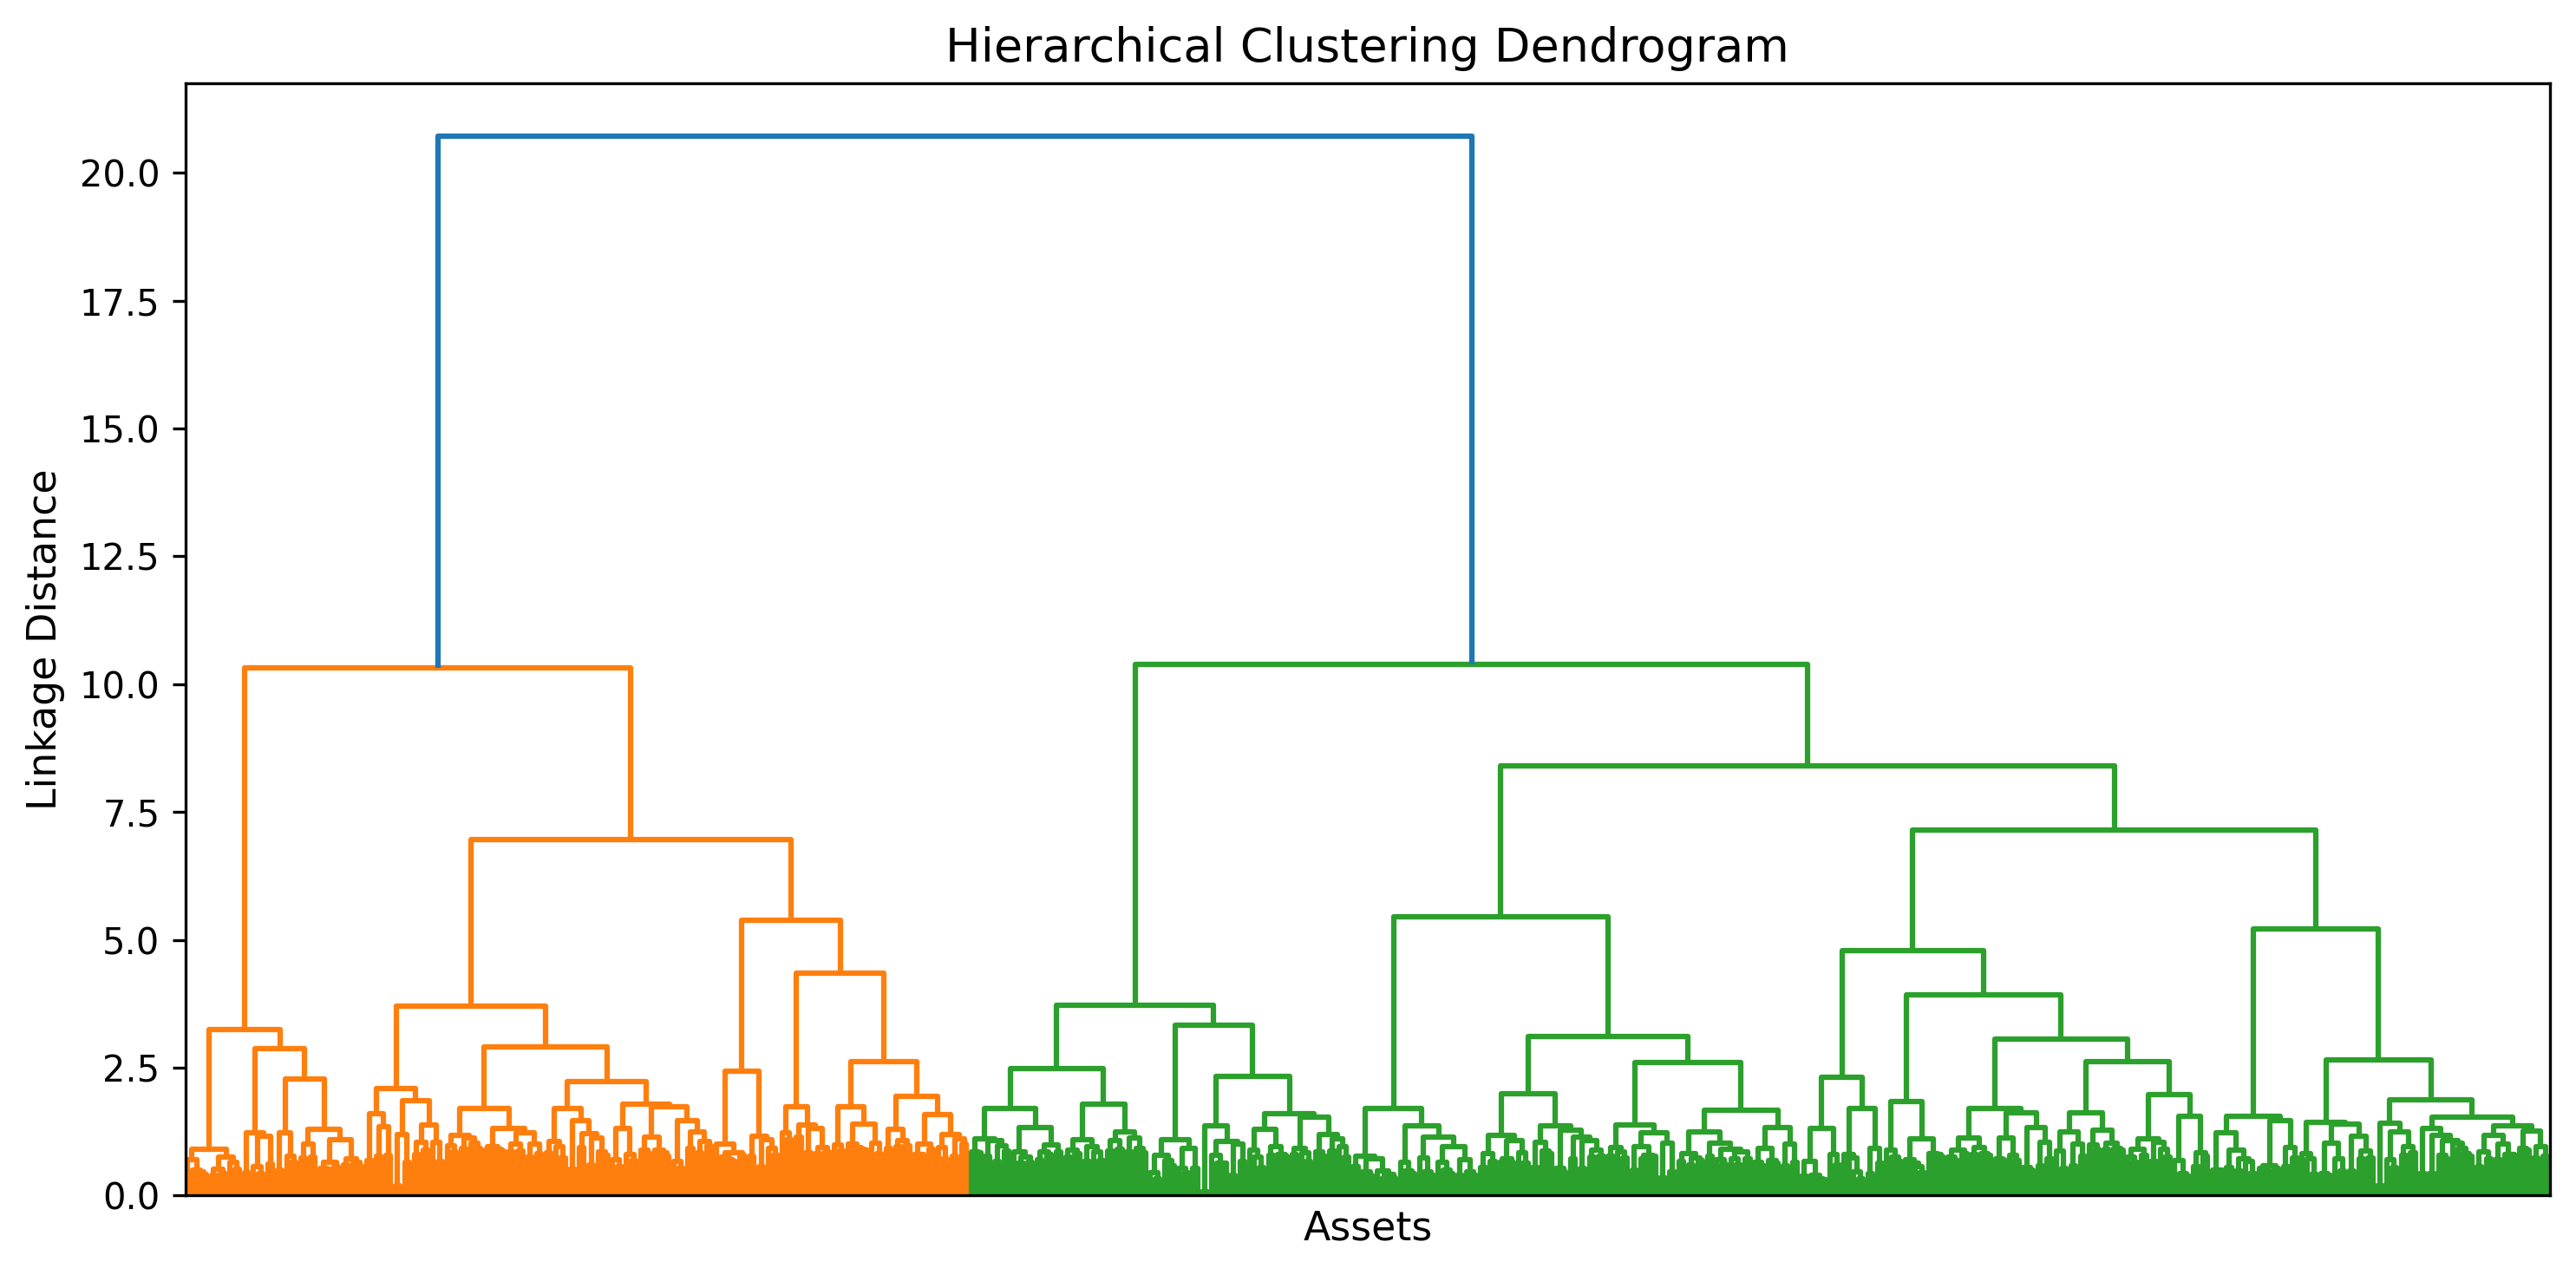

In [22]:
plt.figure(figsize=(10, 5), dpi=300)
dendrogram(
    linkage_matrix,
    no_labels=True
)

plt.title('Hierarchical Clustering Dendrogram', fontsize=13)
plt.xlabel('Assets', fontsize=11)
plt.ylabel('Linkage Distance', fontsize=11)
plt.xticks([])
plt.tight_layout()
plt.show()


In [23]:
assets = corr.columns.tolist()
N = n_assets = len(assets)


In [24]:
corr_df = pct_returns.corr()
n_assets = corr_df.shape[0]
idx_map = {name: i for i, name in enumerate(assets)}

In [25]:
n_assets

501

cluster analysis

In [26]:
print("\n" + "="*60)
print("--- Analysis 1: Cluster Sizes at Various Levels ---")
print("="*60)

# Compute for all levels
level_sizes = {
    k: pd.Series(fcluster(linkage_matrix, t=k, criterion='maxclust')).value_counts().sort_index().tolist()
    for k in range(1, n_assets + 1)
}

# Show only selected levels
levels_to_show = [1, 2, 3, 5, n_assets]
for k in levels_to_show:
    if k in level_sizes:
        print(f"Level {k:3d} (i.e., {k} clusters): cluster sizes: {level_sizes[k]}")

print("\n" + "="*60)
print("--- Analysis 2: Cluster Members at Each Level ---")
print("="*60)

# Compute for all levels
clusters_by_level = {}
for k in range(1, n_assets + 1):
    labels = fcluster(linkage_matrix, t=k, criterion='maxclust')
    level_clusters = {}
    for cl_id in np.unique(labels):
        members = [corr.columns[i] for i, lab in enumerate(labels) if lab == cl_id]
        level_clusters[int(cl_id)] = members
    clusters_by_level[k] = level_clusters

# Show for one level
level_to_show = 5
print(f'Clusters @ level {level_to_show}:')
if level_to_show in clusters_by_level:
    for cid, members in clusters_by_level[level_to_show].items():
        print(f"  Cluster {cid}: {members}")
else:
    print(f"Level {level_to_show} is not available.")

print("\n" + "="*60)
print(f"--- Analysis 3: Tracking a Specific Asset ('GOOG') ---")
print("="*60)

asset_to_track = 'GOOG'
asset_clusters = [
    (level, cl_id, members)
    for level, clusters in clusters_by_level.items()
    for cl_id, members in clusters.items()
    if asset_to_track in members
]

# Sort by cluster size
asset_clusters.sort(key=lambda x: len(x[2]))

# Show only a few levels
for level, cl_id, members in asset_clusters:
    if level in levels_to_show:
        print(f"Level {level:2d} | Cluster {cl_id} ({len(members):2d} members) → {members}")

print("\n" + "="*60)
print("--- Analysis 4: Largest Cluster at Each Level ---")
print("="*60)

# Show largest clusters only at selected levels
for level in levels_to_show:
    clusters = clusters_by_level.get(level, {})
    if clusters:
        max_cl_id, max_members = max(clusters.items(), key=lambda item: len(item[1]))
        print(f"Level {level:2d} | Largest is cluster {max_cl_id} ({len(max_members):2d} members) → {max_members}")



--- Analysis 1: Cluster Sizes at Various Levels ---
Level   1 (i.e., 1 clusters): cluster sizes: [501]
Level   2 (i.e., 2 clusters): cluster sizes: [166, 335]
Level   3 (i.e., 3 clusters): cluster sizes: [166, 81, 254]
Level   5 (i.e., 5 clusters): cluster sizes: [38, 128, 81, 95, 159]
Level 501 (i.e., 501 clusters): cluster sizes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [27]:
clusters = {i: [corr_df.columns[i]] for i in range(n_assets)}

Find sign of $\Sigma_{AB}$

In [28]:
results = []

for i in range(linkage_matrix.shape[0]):
    cluster_id_1 = int(linkage_matrix[i, 0])
    cluster_id_2 = int(linkage_matrix[i, 1])
    members_A = clusters[cluster_id_1]
    members_B = clusters[cluster_id_2]
    sub_corr = corr_df.loc[members_A, members_B]
    all_positive = (sub_corr.values > 0).all()
    all_negative = (sub_corr.values < 0).all()
    if all_positive:
        results.append('+')
    elif all_negative:
        results.append('N')
    else:
        results.append('Mixed')
    new_cluster_id = n_assets + i
    clusters[new_cluster_id] = members_A + members_B

500 merging steps

In [29]:
np.array(results) # N-1 ENTRIES, START FROM -1TH INDEX FOR LEVEL N (N CLUSTERS) AND AT LEVEL N+1 (1 CLUSTER)

array(['+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+',
       '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+

In [30]:
active_levels = set()
i = 0
while i < len(results):
    level_type = results[i]
    num_clusters_before = N - i
    num_clusters_after = N - 1 - i

    if level_type == '+':
        active_levels.add(num_clusters_after)
        if num_clusters_before in active_levels:
            active_levels.remove(num_clusters_before)
    elif level_type == 'N':
        active_levels.add(num_clusters_before)
        while i < len(results) - 1 and results[i + 1] == 'N':
            i += 1
    elif level_type == 'Mixed':
        active_levels.add(num_clusters_before)
        active_levels.add(num_clusters_after)
    
    i += 1

active_levels.add(1)

print(sorted(active_levels))



[1, 2, 4, 7, 9, 12, 24, 43, 69]


In [31]:
lw = LedoitWolf(store_precision=False, assume_centered=False)
lw.fit(pct_returns.values)
sigma = lw.covariance_

In [32]:
clusters_by_level.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [33]:
active_levels

{1, 2, 4, 7, 9, 12, 24, 43, 69}

In [34]:
mu = pct_returns.mean(axis=0).to_dict()

In [35]:
# DAY 2 DAY RETs

In [36]:
delta = 5/(100*251)
delta

0.00019920318725099602

In [37]:
lw = LedoitWolf(store_precision=False, assume_centered=False)
lw.fit(pct_returns.values)
sigma = lw.covariance_

idx = {name: i for i, name in enumerate(assets)}
N   = len(assets)



In [38]:
model = Model("clustered_portfolio_optimization")
model.setParam('OutputFlag', 1)

w = model.addVars(N, lb=0.0, name="w")
z = model.addVar(name="z")

model.addConstr(quicksum(w[i] for i in range(N)) == 1.0, "budget")

for level in active_levels:
    clusters = clusters_by_level[level]
    for k, members in enumerate(clusters.values()):
        expr = QuadExpr()
        indices = [idx[name] for name in members]
        for i in indices:
            for j in indices:
                expr.add(sigma[i, j] * w[i] * w[j])
        model.addQConstr(z >= expr, name=f"risk_l{level}_c{k}")

exp_ret = quicksum(mu[assets[i]] * w[i] for i in range(N))
avg_ret = sum(mu.values()) / N
model.addConstr(exp_ret >= avg_ret, "min_return")

model.setObjective(z, GRB.MINIMIZE)

model.optimize()

weightsA = np.array([w[i].X for i in range(N)])

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2579375
Academic license 2579375 - for non-commercial use only - registered to ma___@iitd.ac.in
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2579375 - for non-commercial use only - registered to ma___@iitd.ac.in
Optimize a model with 2 rows, 502 columns and 1002 nonzeros
Model fingerprint: 0x13db9fb4
Model has 171 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  QMatrix range    [7e-08, 3e-03]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+00]
Presolve time: 0.14s
Presolved: 4853 rows, 5353 columns, 310621 nonzeros
Presolved model has 171 second-order cone constraints
Ordering time: 0.03s

Barrier stat

NOTE:: This formulation doesnt contain $\delta$ as of now, to include it


use ```model.addConstr(exp_ret >= avg_ret + delta, "min_return")```


In [39]:
weightsA = np.array(weightsA)

mean_weight = weightsA.mean()
max_weight = weightsA.max()
min_weight = weightsA.min()

print(f"Mean: {mean_weight:.9f} (1/501 ≈ {1/501:.9f})")
print(f"Max : {max_weight:.6f}")
print(f"Min : {min_weight:.6f}")


Mean: 0.001996008 (1/501 ≈ 0.001996008)
Max : 0.032764
Min : 0.000275


In [40]:
weightsA[weightsA.argmax()], weightsA[weightsA.argmin()]

(0.032763524757250834, 0.00027452732097661106)

In [41]:
assets[weightsA.argmax()], assets[weightsA.argmin()]

('NVDA', 'VTRS')

In [42]:
hrp = HRPOpt(returns=pct_returns)
hrp.optimize(linkage_method="ward")
hrp_weights = hrp.clean_weights()
performance = hrp.portfolio_performance(verbose=True)
hrpweights_values = np.array(list(hrp_weights.values()))

Expected annual return: 12.9%
Annual volatility: 14.2%
Sharpe Ratio: 0.91


In [43]:
print('='*10, 'HRP', '='*10)
sorted_indices_hrp = np.argsort(hrpweights_values)
print("Bottom 10 Stocks:")
for i in sorted_indices_hrp[:10]:
    print(f"{assets[i]}: {100 * hrpweights_values[i]:.4f}%")

# Top 10
print("\nTop 10 Stocks:")
for i in sorted_indices_hrp[-10:][::-1]:
    print(f"{assets[i]}: {100 * hrpweights_values[i]:.4f}%")


========== HRP ==========
Bottom 10 Stocks:
NCLH: 0.0330%
APA: 0.0380%
SMCI: 0.0390%
ON: 0.0400%
CZR: 0.0420%
RCL: 0.0430%
FANG: 0.0430%
CCL: 0.0450%
ENPH: 0.0450%
FCX: 0.0470%

Top 10 Stocks:
VLTO: 4.4500%
SW: 3.3610%
KVUE: 3.2200%
SOLV: 3.0100%
GEHC: 1.8050%
GEV: 0.7400%
JNJ: 0.5710%
KMB: 0.5370%
OTIS: 0.5230%
VZ: 0.5100%


In [44]:
print('='*10, 'Our', '='*10)
sorted_indices_our = np.argsort(weightsA)
print("Bottom 10 Stocks:")
for i in sorted_indices_our[:10]:
    print(f"{assets[i]}: {100 * weightsA[i]:.4f}%")

# Top 10
print("\nTop 10 Stocks:")
for i in sorted_indices_our[-10:][::-1]:
    print(f"{assets[i]}: {100 * weightsA[i]:.4f}%")


========== Our ==========
Bottom 10 Stocks:
VTRS: 0.0275%
WBA: 0.0314%
KHC: 0.0665%
PARA: 0.0695%
BIIB: 0.0697%
KVUE: 0.0740%
WBD: 0.0773%
CAG: 0.0824%
CPB: 0.0836%
SW: 0.0856%

Top 10 Stocks:
NVDA: 3.2764%
AMD: 2.3897%
ENPH: 1.7393%
SMCI: 1.6448%
TSLA: 1.2058%
AXON: 0.9813%
ANET: 0.9731%
AVGO: 0.9486%
MPWR: 0.9300%
KLAC: 0.8456%


SAVING

In [45]:
np.save(NAMESAVE, weightsA)

##  Analysis

In [46]:
weights1 = weightsA
weights2 = hrpweights_values

In [47]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(url)[0]

sector_groups = sp500.groupby("GICS Sector")["Symbol"].apply(list)
tot = 0
for sector, tickers in sector_groups.items():
    tot += len(tickers)
    print(f"\n{sector} ({len(tickers)} tickers):")
    print(tickers[:10], '....')


Communication Services (24 tickers):
['GOOGL', 'GOOG', 'T', 'CHTR', 'CMCSA', 'EA', 'FOXA', 'FOX', 'IPG', 'LYV'] ....

Consumer Discretionary (51 tickers):
['ABNB', 'AMZN', 'APTV', 'AZO', 'BBY', 'BKNG', 'CZR', 'KMX', 'CCL', 'CMG'] ....

Consumer Staples (38 tickers):
['MO', 'ADM', 'BF.B', 'BG', 'CPB', 'CHD', 'CLX', 'KO', 'CL', 'CAG'] ....

Energy (23 tickers):
['APA', 'BKR', 'CVX', 'COP', 'CTRA', 'DVN', 'FANG', 'EOG', 'EQT', 'EXE'] ....

Financials (73 tickers):
['AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'APO', 'ACGL', 'AJG', 'AIZ'] ....

Health Care (60 tickers):
['ABT', 'ABBV', 'A', 'ALGN', 'AMGN', 'BAX', 'BDX', 'TECH', 'BIIB', 'BSX'] ....

Industrials (78 tickers):
['MMM', 'AOS', 'ALLE', 'AME', 'ADP', 'AXON', 'BA', 'BR', 'BLDR', 'CHRW'] ....

Information Technology (68 tickers):
['ACN', 'ADBE', 'AMD', 'AKAM', 'APH', 'ADI', 'AAPL', 'AMAT', 'ANET', 'ADSK'] ....

Materials (26 tickers):
['APD', 'ALB', 'AMCR', 'AVY', 'BALL', 'CF', 'CTVA', 'DOW', 'DD', 'EMN'] ....

Real Estate (31 ticker

In [48]:
weight_map1 = {assets[i]: weights1[i] for i in range(N)}
weight_map2 = {assets[i]: weights2[i] for i in range(N)}

In [49]:
sector_weight1 = {}
for sector, tickers in sector_groups.items():
    total_weight = 0.0
    for ticker in tickers:
        if ticker in weight_map1:
            total_weight += weight_map1[ticker]
        else:
            print(f"{ticker} NOT FOUND")
    sector_weight1[sector] = total_weight
print('+'*50)
sector_weight2 = {}
for sector, tickers in sector_groups.items():
    total_weight = 0.0
    for ticker in tickers:
        if ticker in weight_map2:
            total_weight += weight_map2[ticker]
        else:
            print(f"{ticker} NOT FOUND")
    sector_weight2[sector] = total_weight

TKO NOT FOUND
TTD NOT FOUND
DASH NOT FOUND
WSM NOT FOUND
BF.B NOT FOUND
EXE NOT FOUND
BRK.B NOT FOUND
COIN NOT FOUND
DDOG NOT FOUND
++++++++++++++++++++++++++++++++++++++++++++++++++
TKO NOT FOUND
TTD NOT FOUND
DASH NOT FOUND
WSM NOT FOUND
BF.B NOT FOUND
EXE NOT FOUND
BRK.B NOT FOUND
COIN NOT FOUND
DDOG NOT FOUND


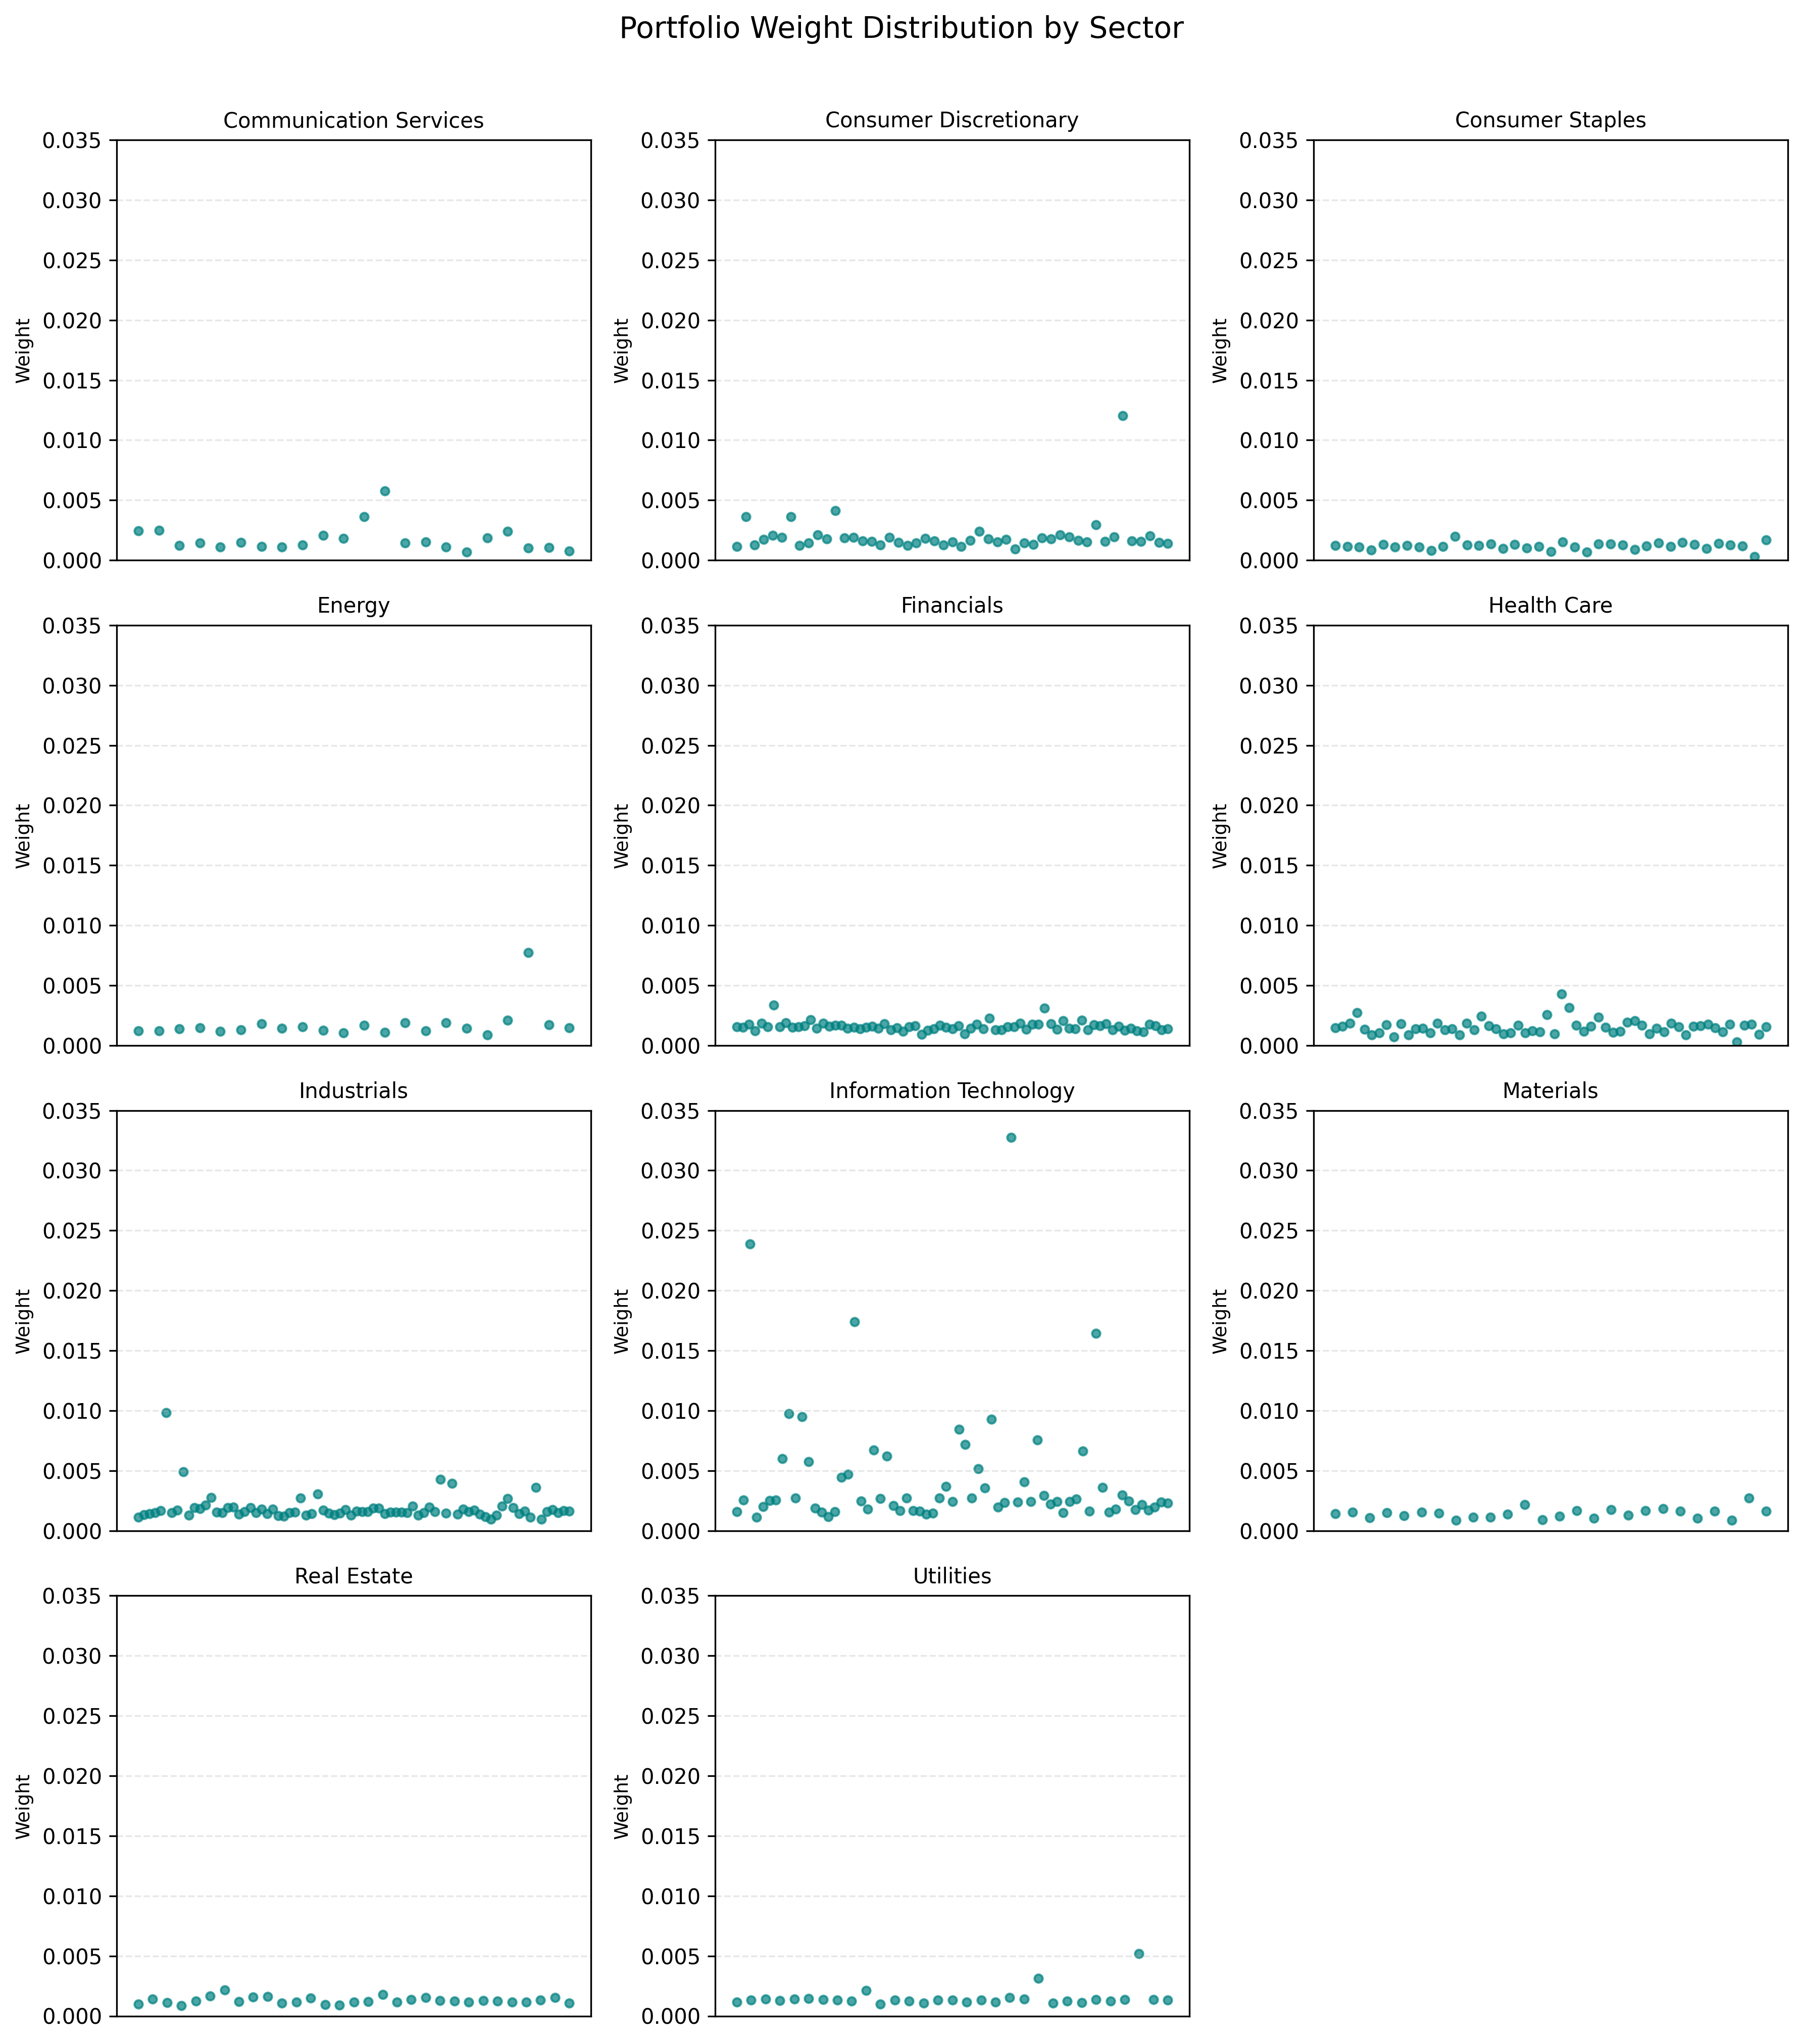

In [50]:
sector_names = list(sector_groups.keys())
n_sectors = len(sector_names)
n_cols = 3
n_rows = (n_sectors + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5 * n_rows), dpi=300)
axes = axes.flatten()

for idx, sector in enumerate(sector_names):
    weights = []
    for asset in sector_groups[sector]:
        if asset in idx_map:
            weights.append(weightsA[idx_map[asset]])

    ax = axes[idx]
    ax.scatter(range(len(weights)), weights, alpha=0.7, color='teal', s=15)
    ax.set_title(sector, fontsize=10)
    ax.set_ylim(0, 0.035)
    ax.set_xticks([])
    ax.set_ylabel('Weight', fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Portfolio Weight Distribution by Sector", fontsize=14)
plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()

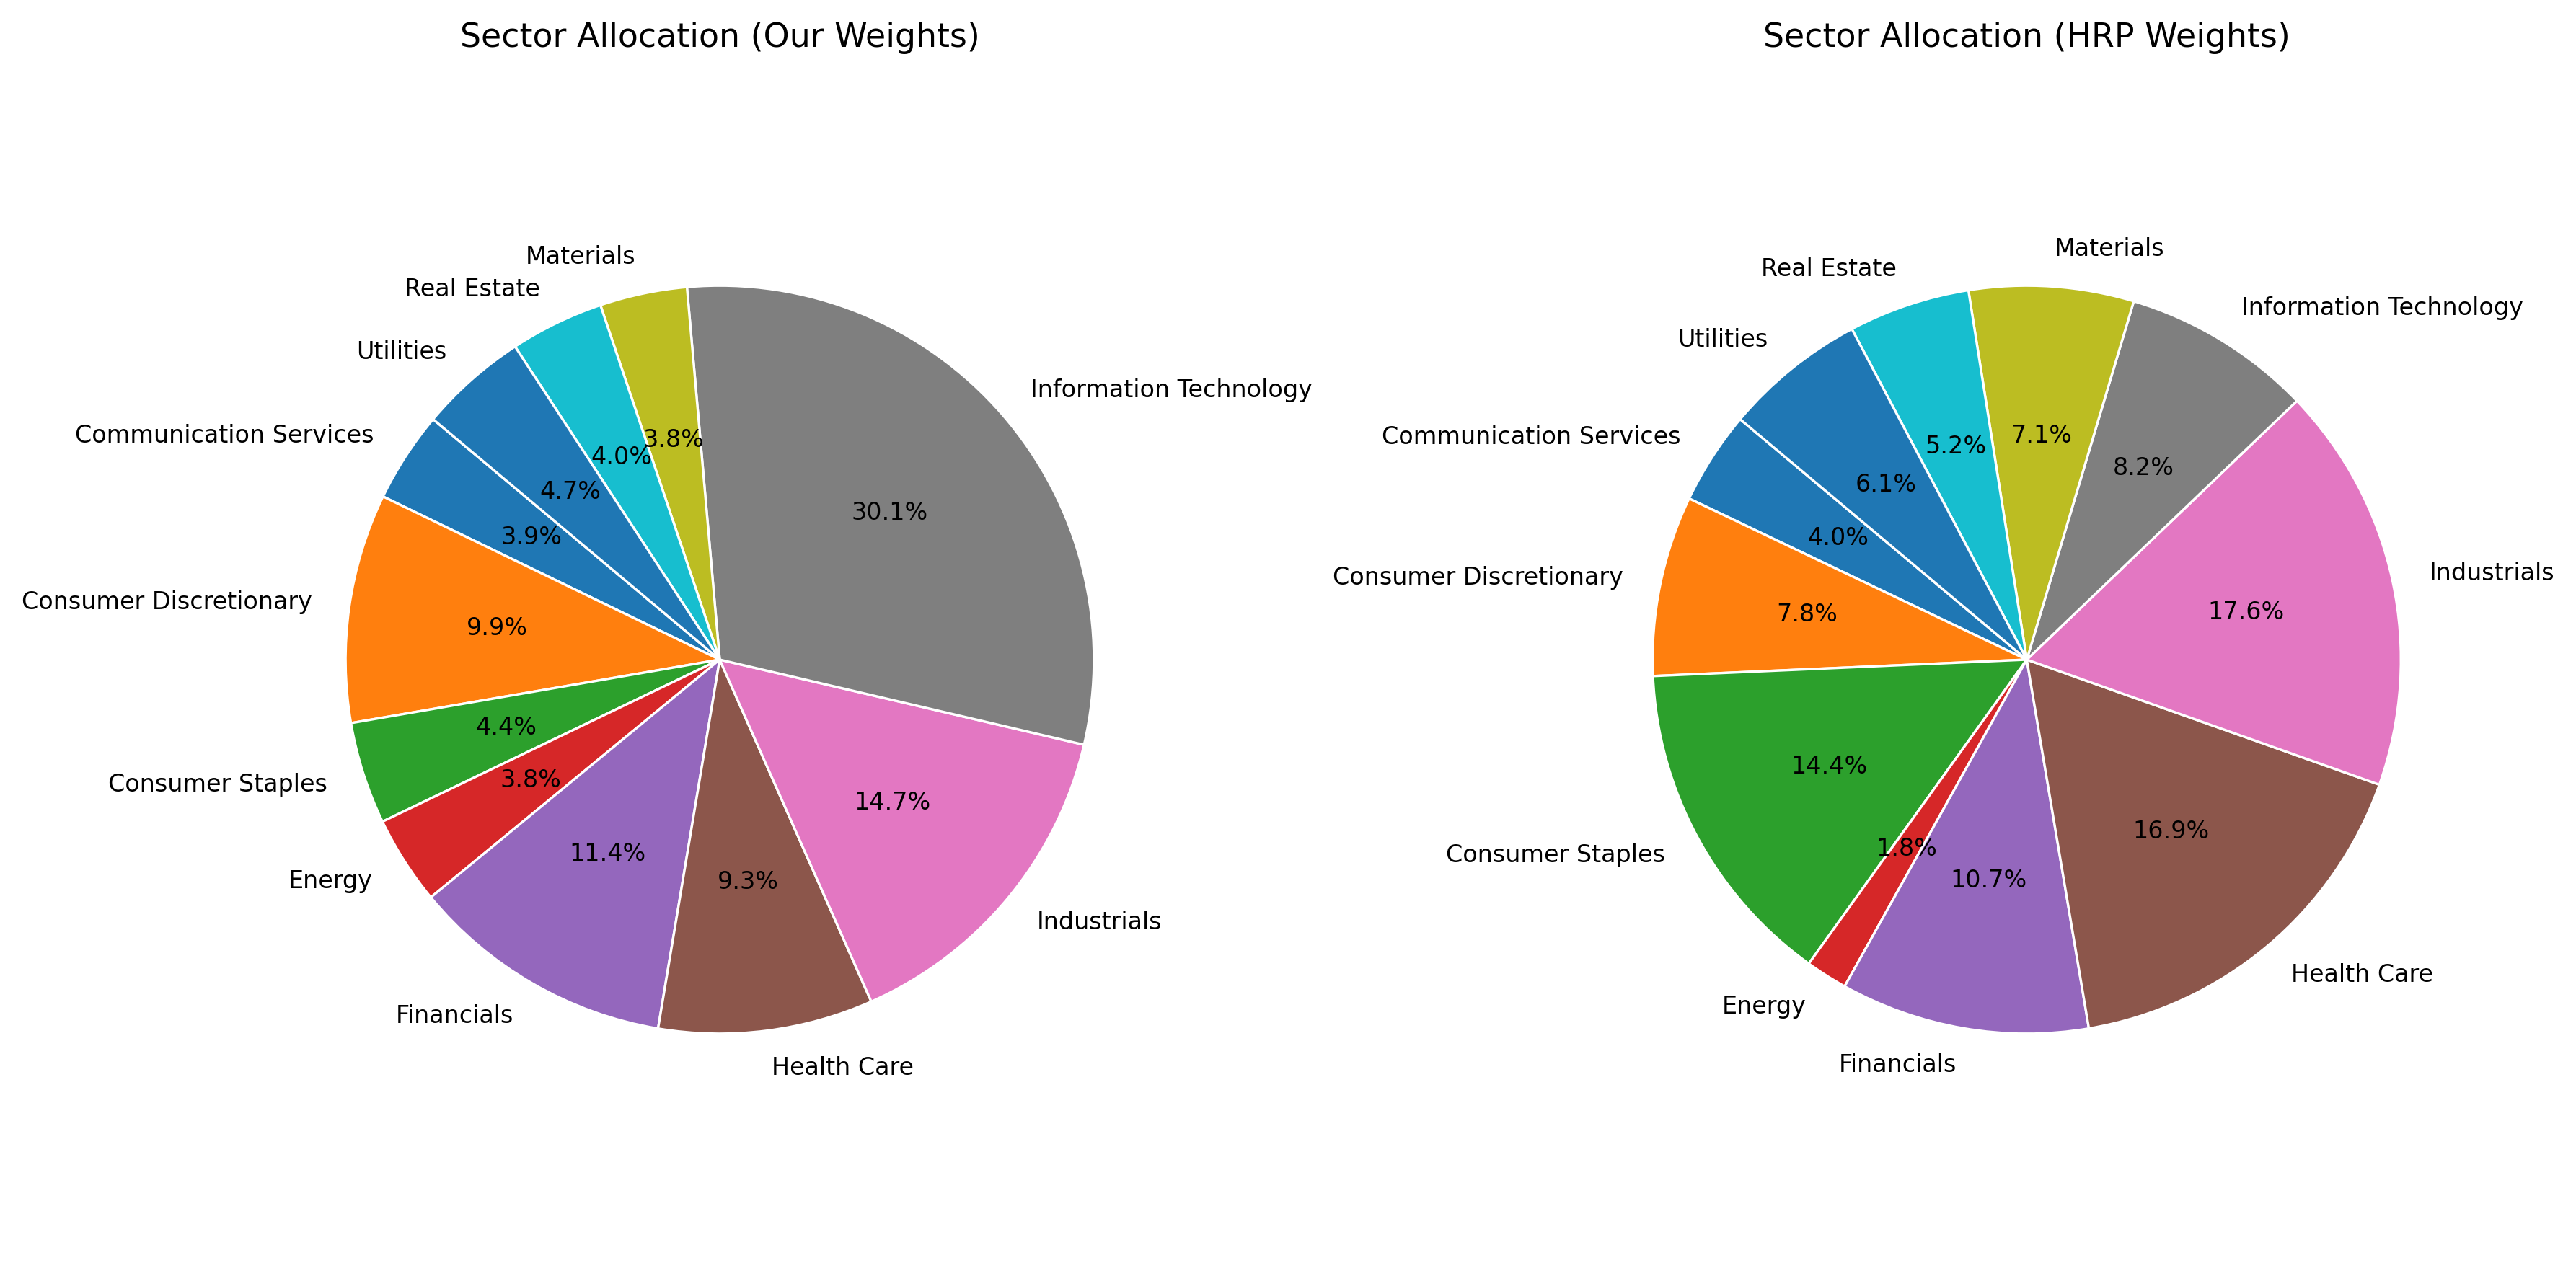

In [51]:
labels1, sizes1 = zip(*[(s, w) for s, w in sector_weight1.items() if w > 0])
labels2, sizes2 = zip(*[(s, w) for s, w in sector_weight2.items() if w > 0])

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

axes[0].pie(
    sizes1,
    labels=labels1,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 8},
    wedgeprops=dict(edgecolor='white', linewidth=0.8)
)
axes[0].set_title("Sector Allocation (Our Weights)", fontsize=11)
axes[0].axis('equal')

axes[1].pie(
    sizes2,
    labels=labels2,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 8},
    wedgeprops=dict(edgecolor='white', linewidth=0.8)
)
axes[1].set_title("Sector Allocation (HRP Weights)", fontsize=11)
axes[1].axis('equal')

plt.tight_layout()
plt.show()


### DIRECTLY COPIED FROM pypfopt

In [52]:
def portfolio_performance(weights, returns, verbose=False, risk_free_rate=0.0, frequency=252):
    if returns is None:
        cov = cov_matrix
        mu = None
    else:
        cov = returns.cov() * frequency
        mu = returns.mean() * frequency

    return base_optimizer.portfolio_performance(
        weights, mu, cov, verbose, risk_free_rate
    )


In [53]:
portfolio_performance(weight_map1 , pct_returns)

(0.2403432721016146, 0.2097455343792701, 1.1458802820898988)

In [54]:
portfolio_performance(weight_map2 , pct_returns)

(0.12917120061653278, 0.14154124350604086, 0.9126046756189469)

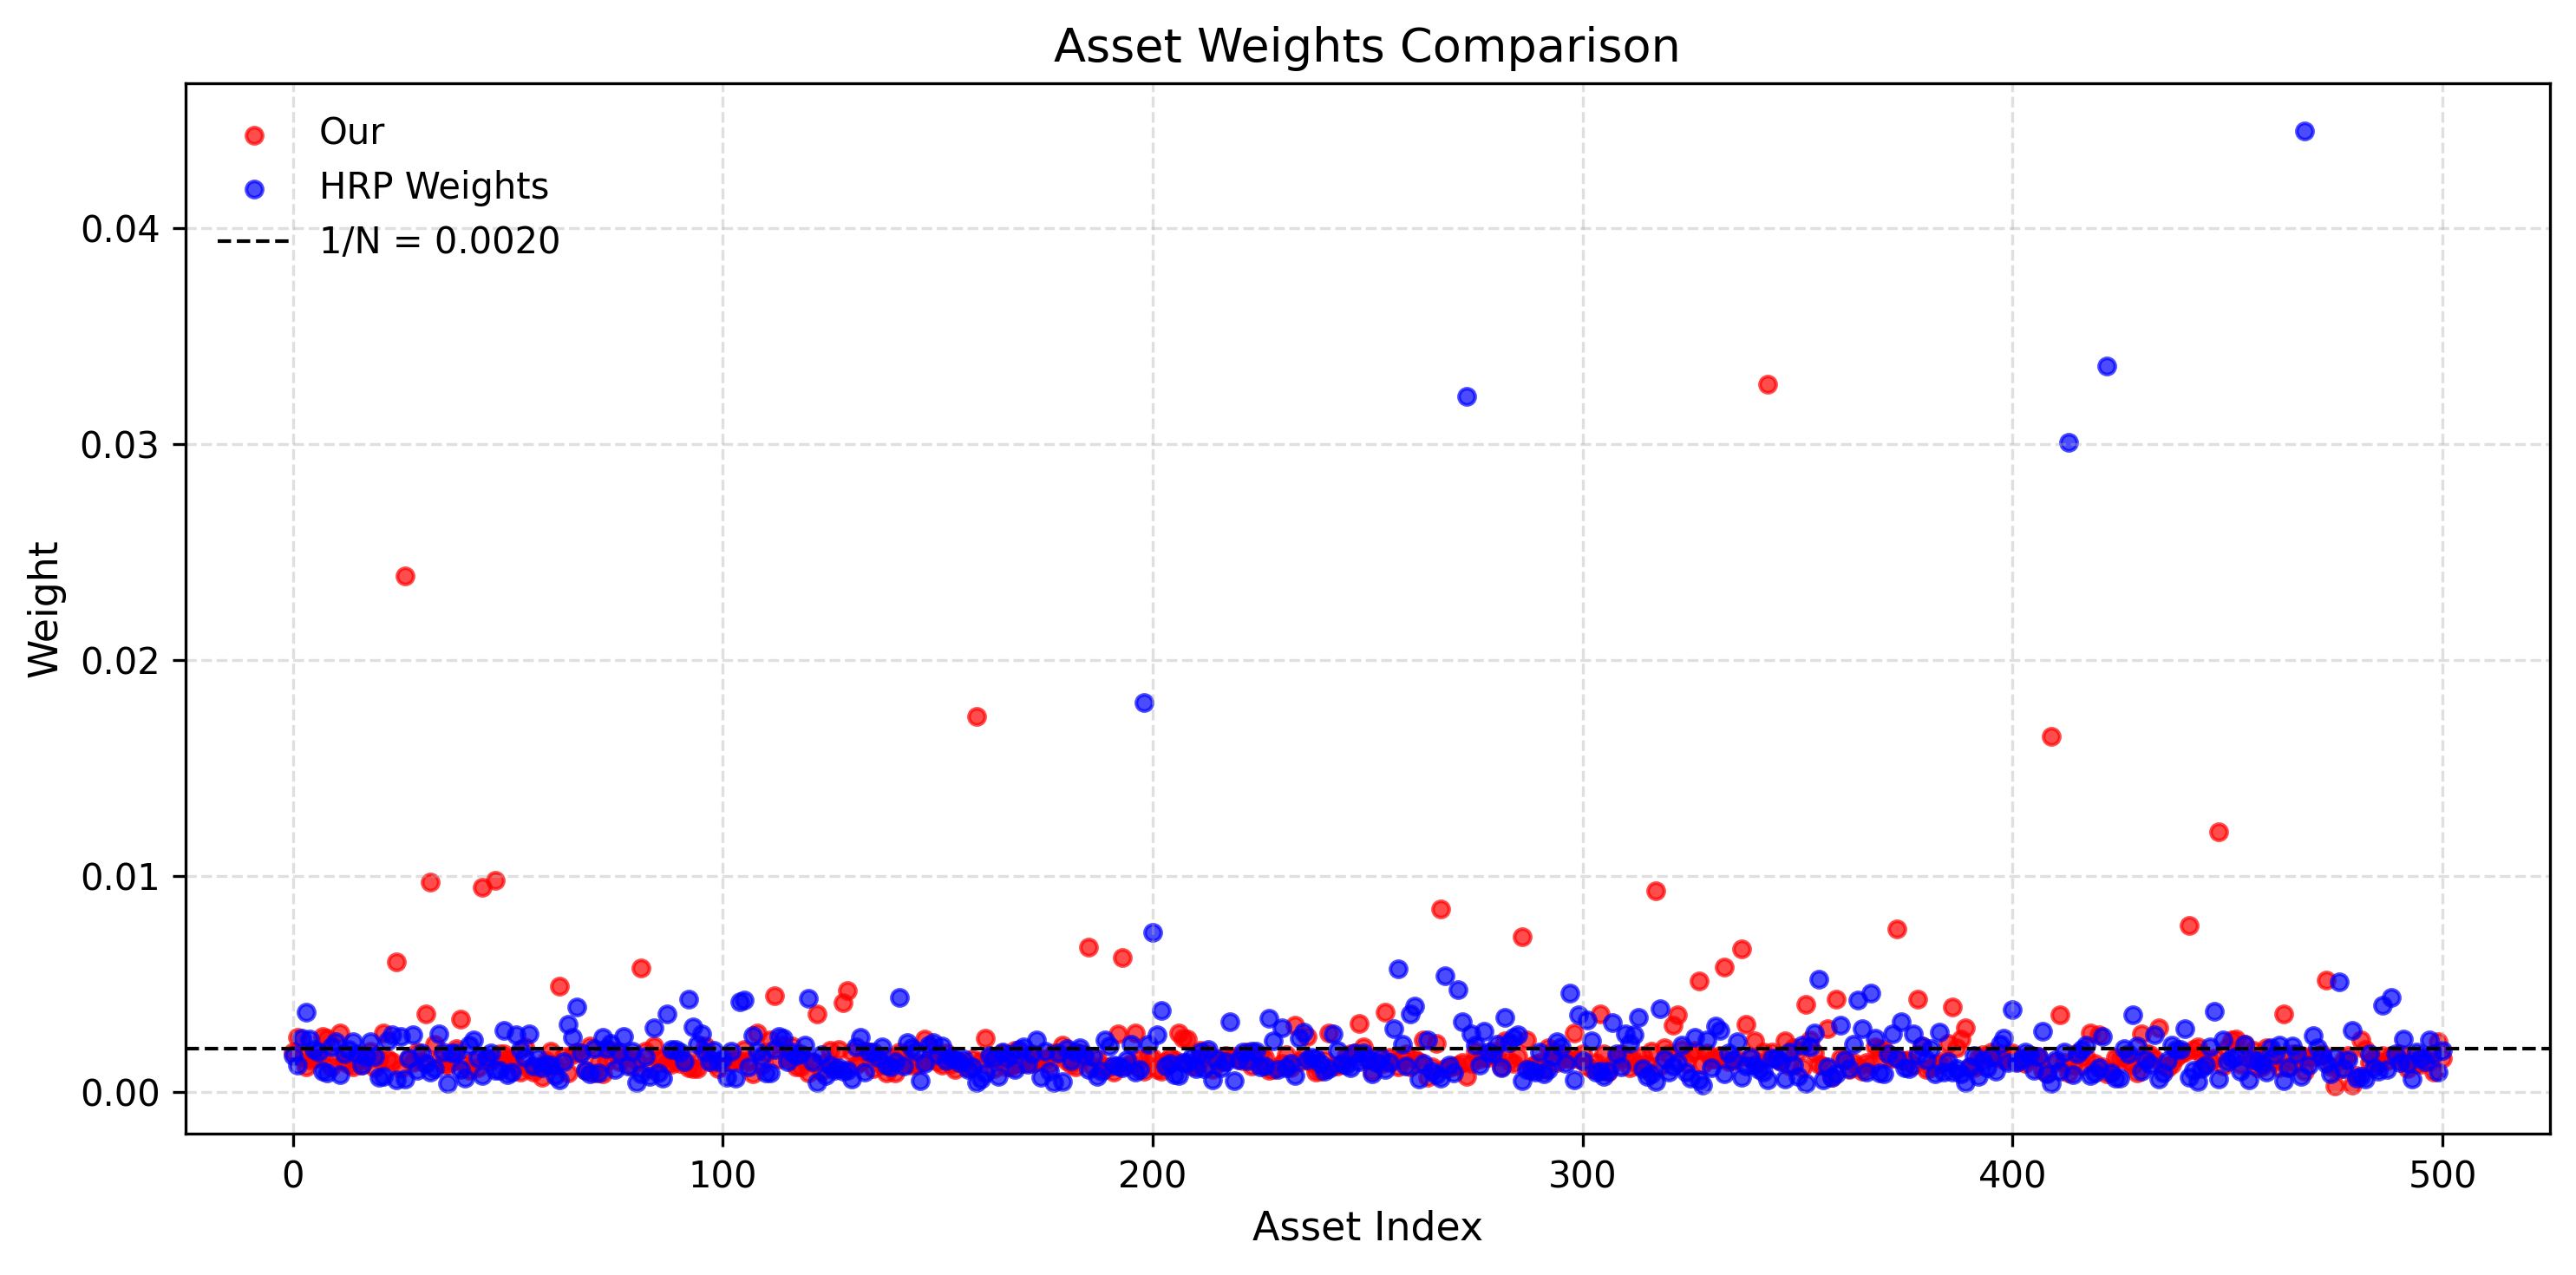

In [55]:
plt.figure(figsize=(10, 5), dpi=300)
plt.scatter(range(len(weightsA)), weightsA, color='red', alpha=0.7, s=20, label='Our')
plt.scatter(range(len(hrpweights_values)), hrpweights_values, color='blue', alpha=0.7, s=20, label='HRP Weights')
mean_weight = weightsA.mean()
mean_weight2 = hrpweights_values.mean()
plt.axhline(1/501, color='black', linestyle='dashed', linewidth=1, label=f'1/N = {1/501:.4f}')
plt.title("Asset Weights Comparison", fontsize=13)
plt.xlabel("Asset Index", fontsize=11)
plt.ylabel("Weight", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=False, fontsize=10)
plt.tight_layout()
plt.show()